# FINETUNING `Mistral-7B-v0.1` ON CUSTOM DATASET NOTEBOOK [`figr`]:

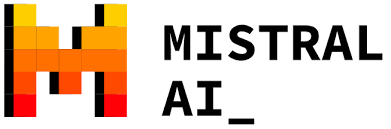

## **Installation**

In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib
!pip install langchain -q
!pip install trl  -q
!pip install -q wandb -U

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()
from datasets import load_dataset

## **Load Data**

In [ ]:
html_dataset = load_dataset('jawerty/html_dataset')

In [ ]:
html_dataset.keys()

dict_keys(['train'])

In [ ]:
html_dataset['train']

Dataset({
    features: ['html', 'label'],
    num_rows: 43
})

In [ ]:
dataset = html_dataset

In [ ]:
import pandas as pd
df_html = pd.DataFrame(dataset['train'])

In [ ]:
df_html.head()

,html,label
0,"<div class=""absolute top-2 left-2 z-50""><a cla...",this is a basic landing page with a email sign up
1,"<div id=""shopify-section-top-hat"" class=""shopi...",a colorful landing page
2,"<div id=""__next"" data-reactroot=""""><div data-d...",this is a colorful landing page with a search bar
3,"<div class=""main-wrapper"" role=""main"">\n <d...",this is a colorful landing page with a search bar
4,"<div class=""site"">\n\t\t<div class=""center"">\n...",a minimalist landing page that has a download ...


In [ ]:
html_dataset['train'].to_pandas()

,html,label
0,"<div class=""absolute top-2 left-2 z-50""><a cla...",this is a basic landing page with a email sign up
1,"<div id=""shopify-section-top-hat"" class=""shopi...",a colorful landing page
2,"<div id=""__next"" data-reactroot=""""><div data-d...",this is a colorful landing page with a search bar
3,"<div class=""main-wrapper"" role=""main"">\n <d...",this is a colorful landing page with a search bar
4,"<div class=""site"">\n\t\t<div class=""center"">\n...",a minimalist landing page that has a download ...
5,"<div class=""site"">\n\t\t<div class=""center"">\n...",this is a minimalist landing page that contain...
6,"<div id=""__next""><div class=""np-theme-light""><...",this is a landing page
7,"<div id=""site-skip-links""><span id=""popups-eve...",a simple landing page
8,"<div id=""site-skip-links""><span id=""popups-eve...",simple landing page
9,"<div id=""__next"" data-reactroot=""""><div class=...",basic landing page


### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config )

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### 3. Tokenization



In [ ]:
len(df_html['html'].max()) , len(df_html['html'].min())

(102565, 108512)

In [ ]:
max_chunk_length = 4096
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

## Pre-Process the data

In [ ]:
print(df_html['html'][0])

<div class="absolute top-2 left-2 z-50"><a class="text-shopifysans font-bold inline-block leading-none overflow-hidden max-w-full transition-all focus-visible:outline-4 focus-visible:outline-focus focus-visible:outline-offset-[-2px] border-solid border-2 rounded-[30px] focus-visible:outline-none tracking-ff-tight border-[transparent] text-shade-100 bg-white hover:bg-shade-30 active:bg-shade-50 disabled:bg-shade-70 disabled:text-shade-90 text-body-sm px-[1.375rem] py-[0.875rem] transition-transform duration-300 translate-y-[-200%] motion-reduce:transition-none focus:translate-y-0 focus:z-[100]" data-component-name="" href="#main">Skip to Content</a></div><div class="relative"><section aria-label="Announcement" class="relative inset-x-0 top-0 flex h-[72px] items-center justify-center overflow-hidden z-20 deafult:text-black default:bg-shopify-green-10" data-section-name="butter-bar"><p class="p-4 pr-16 sm:pl-16 md:py-5 md:px-20 text-xs sm:text-sm md:text-base lg:text-lg sm:text-center fon

In [ ]:
html_token_counts= [len(tokenizer.tokenize(example['html'])) for example in dataset['train']]

print("MAX HTML TOKEN COUNTS " , max(html_token_counts))

MAX HTML TOKEN COUNTS  165075


In [ ]:
query_token_count = [len(tokenizer.tokenize(example['label'])) for example in dataset['train']]

In [ ]:
max(query_token_count)

12

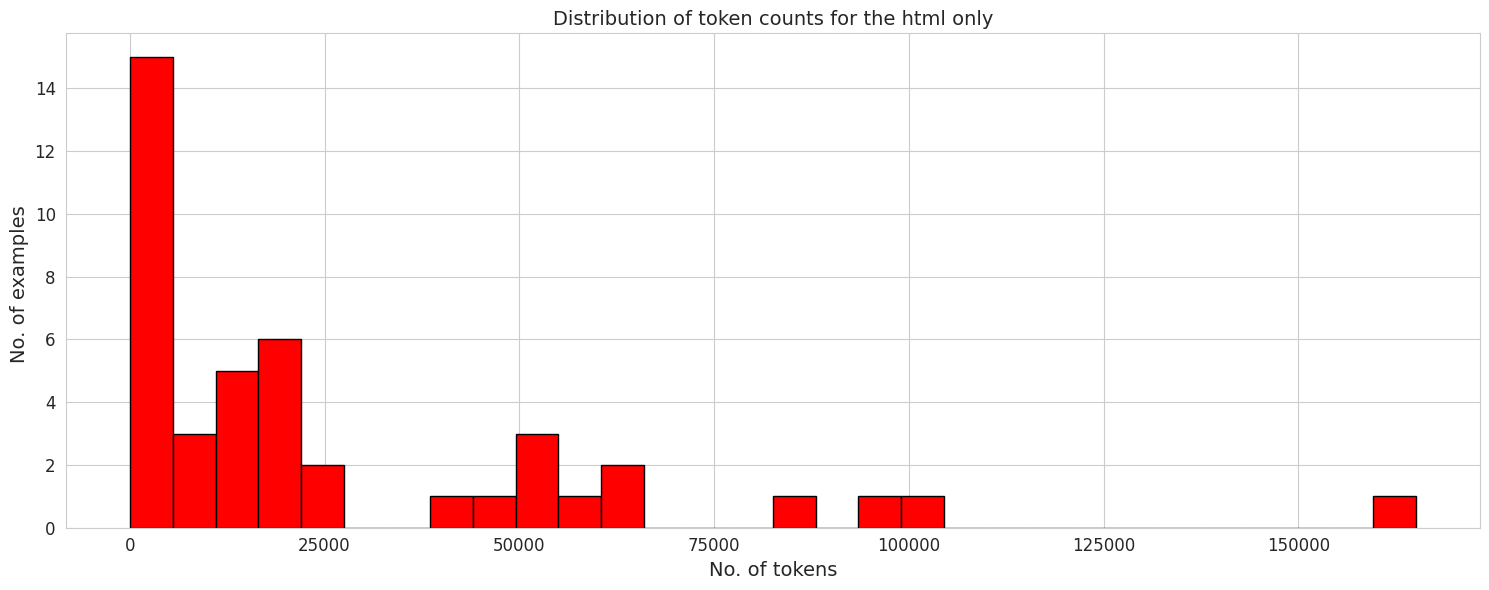

In [ ]:
import seaborn as sns

def plot_distribution(token_counts, title):
  sns.set_style('whitegrid')
  plt.figure(figsize=(15,6))
  plt.hist(token_counts , bins=30 , color='red' , edgecolor='black')
  plt.title(title, fontsize=14)
  plt.xlabel('No. of tokens' , fontsize=14)
  plt.ylabel('No. of examples ' , fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

plot_distribution(html_token_counts , 'Distribution of token counts for the html only')

In [ ]:
print("Average html code length is : " , int(sum(html_token_counts) / len(html_token_counts)))

Average html code length is :  26960


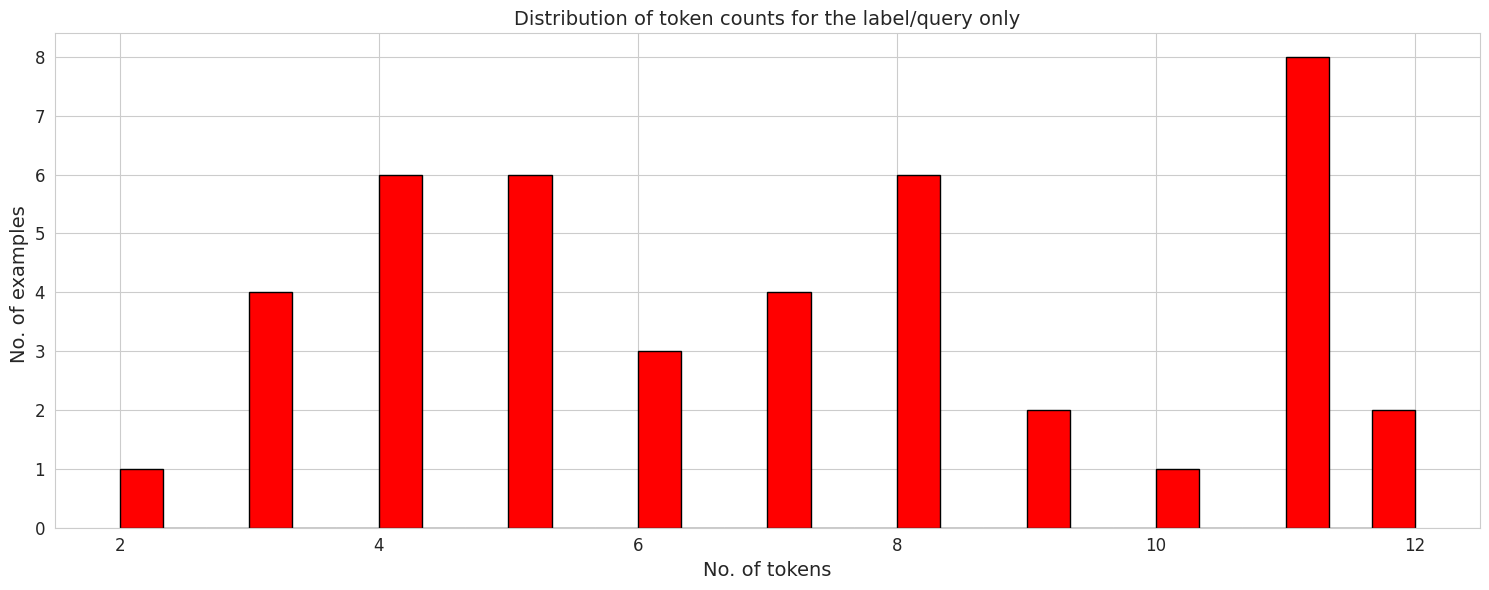

In [ ]:
plot_distribution(query_token_count , 'Distribution of token counts for the label/query only')

### Splitting/ Chunking

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=4096,
    chunk_overlap = 256,
    separators=['</p>' ,'</div>']
)

In [ ]:
chunks = text_splitter.split_text(df_html['html'][0])
len(chunks)

16

In [ ]:
print(chunks[0])

<div class="absolute top-2 left-2 z-50"><a class="text-shopifysans font-bold inline-block leading-none overflow-hidden max-w-full transition-all focus-visible:outline-4 focus-visible:outline-focus focus-visible:outline-offset-[-2px] border-solid border-2 rounded-[30px] focus-visible:outline-none tracking-ff-tight border-[transparent] text-shade-100 bg-white hover:bg-shade-30 active:bg-shade-50 disabled:bg-shade-70 disabled:text-shade-90 text-body-sm px-[1.375rem] py-[0.875rem] transition-transform duration-300 translate-y-[-200%] motion-reduce:transition-none focus:translate-y-0 focus:z-[100]" data-component-name="" href="#main">Skip to Content</a></div><div class="relative"><section aria-label="Announcement" class="relative inset-x-0 top-0 flex h-[72px] items-center justify-center overflow-hidden z-20 deafult:text-black default:bg-shopify-green-10" data-section-name="butter-bar"><p class="p-4 pr-16 sm:pl-16 md:py-5 md:px-20 text-xs sm:text-sm md:text-base lg:text-lg sm:text-center fon

In [ ]:
## generate uuid for the labels

import uuid

def generate_short_uuid():
    full_uuid = str(uuid.uuid4())
    return full_uuid[:12]

short_uuid = generate_short_uuid()
print("Test Generated Short UUID:", short_uuid)

Test Generated Short UUID: 1867d8a9-28f


In [ ]:
dataset['train']['html'][0]

'<div class="absolute top-2 left-2 z-50"><a class="text-shopifysans font-bold inline-block leading-none overflow-hidden max-w-full transition-all focus-visible:outline-4 focus-visible:outline-focus focus-visible:outline-offset-[-2px] border-solid border-2 rounded-[30px] focus-visible:outline-none tracking-ff-tight border-[transparent] text-shade-100 bg-white hover:bg-shade-30 active:bg-shade-50 disabled:bg-shade-70 disabled:text-shade-90 text-body-sm px-[1.375rem] py-[0.875rem] transition-transform duration-300 translate-y-[-200%] motion-reduce:transition-none focus:translate-y-0 focus:z-[100]" data-component-name="" href="#main">Skip to Content</a></div><div class="relative"><section aria-label="Announcement" class="relative inset-x-0 top-0 flex h-[72px] items-center justify-center overflow-hidden z-20 deafult:text-black default:bg-shopify-green-10" data-section-name="butter-bar"><p class="p-4 pr-16 sm:pl-16 md:py-5 md:px-20 text-xs sm:text-sm md:text-base lg:text-lg sm:text-center fo

In [ ]:
len(dataset['train']['html'][42])

108512

In [ ]:
len(dataset['train']['html'])

43

In [ ]:
dataset['train']['label']

['this is a basic landing page with a email sign up',
 'a colorful landing page',
 'this is a colorful landing page with a search bar',
 'this is a colorful landing page with a search bar',
 'a minimalist landing page that has a download button',
 'this is a minimalist landing page that contains a download button',
 'this is a landing page',
 'a simple landing page',
 'simple landing page',
 'basic landing page',
 'a bold landing page',
 'landing page',
 'professional landing page that contains a download form',
 'this is a basic login page',
 'colorful login page with a lead image',
 'a basic login page that contains a video',
 'simple login page that includes a lead image',
 'a simple login page that has a lead image',
 'fun login page with a social buttons',
 'a clean login page',
 'a minimalist login page',
 'a login page that has a only social buttons',
 'a login page',
 'simple sign up page',
 'sign up page',
 'a colorful sign up page',
 'colorful sign up page',
 'a sign up page 

In [ ]:
import tqdm
import uuid

documents = []

for code in tqdm.tqdm(range(len(dataset['train']['html']))):
    unique_id = generate_short_uuid()
    chunks = text_splitter.split_text(dataset['train']['html'][code])

    for i, chunk in enumerate(chunks):
        documents.append({
            'id': f'{unique_id}',
            'html': chunk,
            'label' : dataset['train']['label'][code]
        })

len(documents)


100%|██████████| 43/43 [00:00<00:00, 278.38it/s]


678

In [ ]:
type(documents)

list

In [ ]:
documents[0]

{'id': 'edb75c48-35c',
 'html': '<div class="absolute top-2 left-2 z-50"><a class="text-shopifysans font-bold inline-block leading-none overflow-hidden max-w-full transition-all focus-visible:outline-4 focus-visible:outline-focus focus-visible:outline-offset-[-2px] border-solid border-2 rounded-[30px] focus-visible:outline-none tracking-ff-tight border-[transparent] text-shade-100 bg-white hover:bg-shade-30 active:bg-shade-50 disabled:bg-shade-70 disabled:text-shade-90 text-body-sm px-[1.375rem] py-[0.875rem] transition-transform duration-300 translate-y-[-200%] motion-reduce:transition-none focus:translate-y-0 focus:z-[100]" data-component-name="" href="#main">Skip to Content</a></div><div class="relative"><section aria-label="Announcement" class="relative inset-x-0 top-0 flex h-[72px] items-center justify-center overflow-hidden z-20 deafult:text-black default:bg-shopify-green-10" data-section-name="butter-bar"><p class="p-4 pr-16 sm:pl-16 md:py-5 md:px-20 text-xs sm:text-sm md:text-b

In [ ]:
documents[0:16]

[{'id': 'edb75c48-35c',
  'html': '<div class="absolute top-2 left-2 z-50"><a class="text-shopifysans font-bold inline-block leading-none overflow-hidden max-w-full transition-all focus-visible:outline-4 focus-visible:outline-focus focus-visible:outline-offset-[-2px] border-solid border-2 rounded-[30px] focus-visible:outline-none tracking-ff-tight border-[transparent] text-shade-100 bg-white hover:bg-shade-30 active:bg-shade-50 disabled:bg-shade-70 disabled:text-shade-90 text-body-sm px-[1.375rem] py-[0.875rem] transition-transform duration-300 translate-y-[-200%] motion-reduce:transition-none focus:translate-y-0 focus:z-[100]" data-component-name="" href="#main">Skip to Content</a></div><div class="relative"><section aria-label="Announcement" class="relative inset-x-0 top-0 flex h-[72px] items-center justify-center overflow-hidden z-20 deafult:text-black default:bg-shopify-green-10" data-section-name="butter-bar"><p class="p-4 pr-16 sm:pl-16 md:py-5 md:px-20 text-xs sm:text-sm md:text

In [ ]:
import pandas as pd

formated_df = pd.DataFrame(documents)

formated_df.head()

,id,html,label
0,edb75c48-35c,"<div class=""absolute top-2 left-2 z-50""><a cla...",this is a basic landing page with a email sign up
1,edb75c48-35c,"</p><button type=""button"" aria-label=""Close an...",this is a basic landing page with a email sign up
2,edb75c48-35c,"</div><div data-partial-name=""shopifyLogoTitle...",this is a basic landing page with a email sign up
3,edb75c48-35c,"</div><div class=""h-lg w-full""></div><h1 class...",this is a basic landing page with a email sign up
4,edb75c48-35c,"</p><div class=""h-lg w-full""></div><div class=...",this is a basic landing page with a email sign up


In [ ]:
formated_df.to_csv('formated_df' , index=False)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['html', 'label'],
        num_rows: 43
    })
})

In [ ]:
# prompt: Using dataframe df: convert the dataframe into dictionary

a= formated_df.to_dict('records')

dict_ = {}

for row in a:
  dict_[row['id']] = row

In [ ]:
dict_.keys()


In [ ]:
formated_dict_dataset = dict_

In [ ]:
# for key , value in formated_dict_dataset.items():
#   print(value['html'])

In [ ]:
for key, value in formated_dict_dataset.items():
    print(f"Key: {key}, Value: {value}")

In [ ]:
keys_list = [key for key in formated_dict_dataset.keys()]

print(keys_list)

keys_list[0]

In [ ]:
formated_dict_dataset['a661d5e7-cb1']['html']

In [ ]:
html_token_counts= [len(tokenizer.tokenize(formated_dict_dataset[example]['html'])) for example in formated_dict_dataset.keys()]
query_token_count = [len(tokenizer.tokenize(formated_dict_dataset[example]['label'])) for example in formated_dict_dataset.keys()]


import seaborn as sns
def plot_distribution(token_counts, title):
  sns.set_style('whitegrid')
  plt.figure(figsize=(15,6))
  plt.hist(token_counts , bins=50 , color='red' , edgecolor='black')
  plt.title(title, fontsize=14)
  plt.xlabel('No. of tokens' , fontsize=14)
  plt.ylabel('No. of examples ' , fontsize=14)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

plot_distribution(html_token_counts , 'Distribution of token counts for the html only')
plot_distribution(query_token_count , 'Distribution of token counts for the Label/Query only')

In [ ]:
combined_counts = [str(inst) + str(output) for inst ,  ouptut in zip(html_token_counts ,query_token_count )]

In [ ]:
plot_distribution(combined_counts , 'Distribution of token counts for html + query only')

## Filter out the rows more than 4096 tokens

## Train Test Split

In [ ]:
len(formated_df)

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(formated_df, test_size=0.2, random_state=42)

In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
train_data.shape , test_data.shape

## Tokenization

### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [ ]:
# def formatting_func(prompt):
#     text = f"### <s>[INST] Using this information : {prompt['key']['html']} answer the Question : {prompt['output']} [/INST]"
#     return text
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
# def tokenize(prompt):
#     result = tokenizer(prompt)
#     result["labels"] = result["input_ids"].copy()
#     return result

In [ ]:
def generate_and_tokenize_prompt(data_point):

  full_prompt = f"""Generate HTML code for a webpage based on the given prompt given. The prompts/labels is as follows:


  "{data_point['label']}"

  Provide HTML,css, js code that accurately represents the given prompt and description. Make sure to include any necessary elements, classes, or attributes mentioned in the prompt along the code and explaination, also maintain the poper format.

  """
  return tokenize(full_prompt)


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)

In [ ]:
train_dataset

Reformat the prompt and tokenize each sample:

In [ ]:
len(train_dataset['label'])

In [ ]:
train_dataset.map(generate_and_tokenize_prompt)

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = test_dataset.map(generate_and_tokenize_prompt)


In [ ]:
# tokenized_train_dataset['labels'][0]

In [ ]:
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["label" , 'html' ,'id'])

In [ ]:
tokenized_val_dataset = tokenized_val_dataset.remove_columns(["label" , 'html' ,'id'])

In [ ]:
tokenized_val_dataset

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size.


In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

Now all the samples should be the same length, `max_length`.

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

In [ ]:
eval_prompt = """Given a user query, generate HTML code for the webpage. Ensure that the HTML is well-formatted and neatly spaced.

### User Query/prompt:
Generate a HTML code snippet for a form that includes fields for entering name, place, and age

### Meaning representation:
"""

In [ ]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

In [ ]:
device = "cuda"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to(device)

In [ ]:
model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=128)[0], skip_special_tokens=True))

## FINETUNING

###  Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [ ]:
print(model)

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
# from peft import LoraConfig, get_peft_model , TaskType

# config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     target_modules=[
#         "q_proj",
#         "k_proj",
#         "v_proj",
#         ],
#     bias="none",
#     lora_dropout=0.05,  # Conventional
#     task_type= TaskType.CAUSAL_LM,
# )

# model = get_peft_model(model, config)
# print_trainable_parameters(model)

In [ ]:
# from transformers import TrainingArguments

# project = "figr-finetune"
# base_model_name = "mistral"
# run_name = base_model_name + "-" + project
# output_dir = "./" + run_name


# training_args = TrainingArguments(
#     output_dir= output_dir,
#     per_device_train_batch_size=1,
#     gradient_accumulation_steps=4,
#     learning_rate = 2e-4,
#     fp16=True,
#     optim='paged_adamw_8bit' ,
#     lr_scheduler_type = 'cosine',
#     warmup_ratio=0.05,
# )

In [ ]:
# from trl import SFTTrainer

# trainer = SFTTrainer(
#     model = model,
#     train_dataset = tokenized_train_dataset,
#     peft_config = config,
#     # dataset_text_field = 'formatetext',
#     formatting_func = formatting_func,
#     tokenizer = tokenizer,
#     args = training_args,
#     max_seq_length = 4096
# )

## Accelerator



In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)


*Let's use Weights & Biases to track our training metrics*.

In [ ]:
#(bug fix (colab))

import locale

print(locale.getpreferredencoding())


def getpreferredencoding(do_setlocale = True):
  return "UTF-8"

locale.getpreferredencoding = getpreferredencoding

In [ ]:
import wandb, os
wandb.login()

wandb_project = "figr-mistral-finetune_01"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

## Run Training!

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "figr-finetune-2"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name



trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        max_steps=300,
        learning_rate=2.5e-5, # Want about 10x smaller than the Mistral learning rate
        logging_steps=50,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!




# trainer = transformers.Trainer(
#     model=model,
#     train_dataset=tokenized_train_dataset,
#     eval_dataset=tokenized_val_dataset,
#     args=transformers.TrainingArguments(
#         output_dir=output_dir,
#         warmup_steps=1,
#         per_device_train_batch_size=2,
#         gradient_accumulation_steps=1,
#         gradient_checkpointing=True,
#         max_steps=50,
#         learning_rate=2.5e-5, # Want a small lr for finetuning
#         fp16=True,
#         optim="paged_adamw_8bit",
#         logging_steps=25,              # When to start reporting loss
#         logging_dir="./logs",        # Directory for storing logs
#         save_strategy="steps",       # Save the model checkpoint every logging step
#         save_steps=25,                # Save checkpoints every 50 steps
#         evaluation_strategy="steps", # Evaluate the model every logging step
#         eval_steps=25,               # Evaluate and save checkpoints every 50 steps
#         do_eval=True,                # Perform evaluation at the end of training
#         # report_to="wandb",           # Comment this out if you don't want to use weights & baises
#         run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
#     ),
#     data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
# )

# model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


In [ ]:
trainer.train()

#### Using pytorch

In [1]:
# import torch
# from torch.utils.data import DataLoader
# from transformers import AdamW
# from datetime import datetime

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model.to(device)
# optimizer = AdamW(model.parameters(), lr=2.5e-5)
# num_epochs = 3

# for epoch in range(num_epochs):
#     model.train()
#     for batch in DataLoader(tokenized_train_dataset, batch_size=2, shuffle=True):
#         inputs = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**inputs)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#     # Validation
#     model.eval()
#     total_eval_loss = 0
#     with torch.no_grad():
#         for batch in DataLoader(tokenized_val_dataset, batch_size=2, shuffle=False):
#             inputs = {k: v.to(device) for k, v in batch.items()}
#             outputs = model(**inputs)
#             total_eval_loss += outputs.loss.item()

#     average_eval_loss = total_eval_loss / len(tokenized_val_dataset)

#     # Logging
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_eval_loss}")

# # to save the trained model
# output_dir = "./" + run_name
# model.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)


### Try the Trained Model!


In [ ]:
!huggingface-cli login

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

## Model evaluation (wandb)
You can view system metrics and model performance by going to wandb.ai and checking the recent run.

In [ ]:
import wandb
trainer.model.save_pretrained("mistral-figr-finetune/checkpoint-50")
wandb.finish()
model.config.use_cache = True

In [ ]:
import wandb
trainer.model.save_pretrained("mistral-figr-finetune/checkpoint-50")
wandb.finish()
model.config.use_cache = True

## Copy model to drive

In [ ]:
!cp -r /content/mistral-figr-finetune-2  /content/drive/MyDrive
!cp -r /content/HuggingAlgorithms  /content/drive/MyDrive

!cp -r /content/logs  /content/drive/MyDrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/HuggingAlgorithms /content/drive


In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-figr-finetune/checkpoint-50")

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [ ]:
eval_prompt = "Generate a html code for the adding button"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

In [ ]:
with torch.no_grad():
    # Generate HTML code using the fine-tuned model
    generated_html = ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)

    # Decode and print the generated HTML code, skipping special tokens
    print(eval_tokenizer.decode(generated_html[0], skip_special_tokens=True))




**END**

